#TP03.1 TP03 - Modelo de lenguaje cha
Utilizar otro dataset y poner en práctica la predicción de próxima palabra

# Preparación y carga de la data

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
from google.colab import drive
# Montar Google Drive
drive.mount('/content/drive')

!pip install PyPDF2
import PyPDF2

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.4 MB/s eta 0:00:00


In [3]:
import os
# Especifica la ruta a la carpeta '10 LLM'
folder_path = '/content/drive/My Drive/[06] UBA/10 LLM/'

# Lista todos los archivos en la carpeta especificada
files = os.listdir(folder_path)

# Especifica la ruta al archivo PDF en Google Drive
file_path = f'/content/drive/My Drive/[06] UBA/10 LLM/El Principito.pdf'

In [4]:
# Abre el archivo PDF desde Google Drive
with open(file_path, 'rb') as file:
    reader = PyPDF2.PdfReader(file)

    # Extraer el texto de todas las páginas
    pdf_text = ''
    for page in reader.pages:
        pdf_text += page.extract_text()

import re
# Reemplaza múltiples espacios por un solo espacio
cleaned_text = re.sub(r'\s+', ' ', pdf_text)

# Imprime el texto limpio
print(cleaned_text[:500])

 El Principito Por Antoine De Saint-Exupéry A Leon Werth: Pido perdón a los niños por haber dedicado este libro a una persona mayor. Tengo una seria excusa: esta persona mayor es el mejor amigo que tengo en el mundo. Tengo otra excusa: esta persona mayor es capaz de entenderlo todo, hasta los libros para niños. Tengo una tercera excusa: esta persona mayor vive en Francia, donde pasa hambre y frío. Verdaderamente necesita consuelo. Si todas esas excusas no bastasen, bien puedo dedicar este libro 


## Elegir el tamaño del contexto
El *contexto* se refiere a la secuencia de datos que el modelo utiliza como entrada para predecir la siguiente parte de la secuencia.

In [5]:
# seleccionamos el tamaño de contexto
max_context_size = 100

# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para paddin

# en este caso el vocabulario es el conjunto único de caracteres que existe en todo la data
chars_vocab = set(cleaned_text)

# la longitud de vocabulario de caracteres es:
len(chars_vocab)

# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

## Tokenizar
Es el proceso de dividir un texto en unidades más pequeñas llamadas "tokens." Estos tokens pueden ser palabras, sub-palabras, caracteres, o cualquier otro tipo de unidad significativa según el contexto y el propósito del análisis.

In [6]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in cleaned_text]
# tokenized_text[:1000]

## Organizando y estructurando el dataset

In [7]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [8]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [9]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [10]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

X.shape
X[0,:10]
y[0,:10]

vocab_size = len(chars_vocab)

# Definición del modelo

Definiendo el modelo
El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas CategoryEncoding que transforma a índices a vectores OHE y TimeDistributed que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [11]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

In [12]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 84)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 200)           │          57,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 84)            │          16,884 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,884 (288.61 KB)

 Trainable params: 73,884 (288.61 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          # Ensure this line is indented at the same level as the previous line
          self.model.save("my_model.keras") # Arrojaba error
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

# Entrenamiento

In [15]:
history_ppl = []
hist = model.fit(X, y, epochs=5, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=100)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 2.1755
 mean perplexity: 8.611429755155617 

Saved new model!
704/704 ━━━━━━━━━━━━━━━━━━━━ 147s 208ms/step - loss: 2.1754
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 1.9424
 mean perplexity: 7.909267232277271 

Saved new model!
704/704 ━━━━━━━━━━━━━━━━━━━━ 199s 204ms/step - loss: 1.9424
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 1.8065
 mean perplexity: 7.325687431425354 

Saved new model!
704/704 ━━━━━━━━━━━━━━━━━━━━ 140s 198ms/step - loss: 1.8065
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 1.7243
 mean perplexity: 7.491439805084314 

704/704 ━━━━━━━━━━━━━━━━━━━━ 141s 197ms/step - loss: 1.7242
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 1.6682
 mean perplexity: 7.595664045623407 

704/704 ━━━━━━━━━━━━━━━━━━━━ 143s 198ms/step - loss: 1.6682


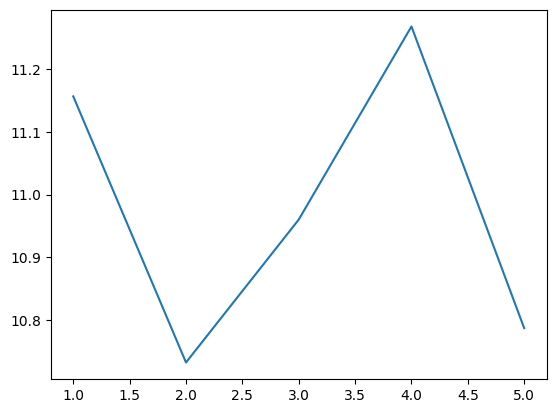

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
#model = keras.models.load_model('my_model')
#model = keras.models.load_model("my_model.keras")
model.save("my_model.keras")



# Predicción del próximo caracter

In [ ]:
!pip install -q gradio
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://9b75cdcbecce719dde.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Generación de secuencias

In [16]:
#Generación de secuencias

def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text


input_text='habia una vez'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)#

'habia una vez se preguntó el principito. —¡'

In [ ]:
# Install necessary packages
!pip install tensorflow  # This will include Keras as well

# Import the necessary modules from TensorFlow/Keras
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences


# largo de la secuencia, incluye seq input + word output
train_len = 4

# Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="habia una vez")

In [ ]:
salidas[0]

In [ ]:
# veamos las salidas
decode(salidas[0])

Referencias:

* https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/tree/main/clase_3/ejercicios

* https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_3/ejercicios/3_modelo_lenguaje_char.ipynb

* https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_3/ejercicios/3_modelo_lenguaje_word.ipynb
